In [21]:
import pandas as pd

# Load CSV file
csv_path_drotrack = '../../../results-Drotrack/Error_info.csv'
csv_path_ours = "results/Error_info_17-12-13-46.csv" 

df_dro = pd.read_csv(csv_path_drotrack, header=None)
df_ours = pd.read_csv(csv_path_ours, header=None)

def get_runs_dict(df):
    runs_dict = {}
    num_cols = df.shape[1]

    for i in range(0, num_cols, 2):  # Step through every 2 columns (IoUs and Center Errors)
        run_title = df.iloc[0, i]  # Extract the title of the test run
        run_title = run_title[7:run_title.index(' ')]

        if pd.isna(run_title):  # Stop if we reach an empty column
            break
        
        # Extract column data (skip the first row as it's the title)
        run_data = df_dro.iloc[2:, [i, i + 1]].copy()
        run_data.columns = ['IoUs', 'Center Errors']  # Rename columns
        
        # Clean up the data (convert to numeric where possible)
        run_data = run_data.apply(pd.to_numeric, errors='coerce')
        
        # Store in the dictionary with the title as the key
        runs_dict[run_title] = run_data.reset_index(drop=True)
    return runs_dict

runs_dict_dro = get_runs_dict(df_dro)
runs_dict_ours = get_runs_dict(df_ours)


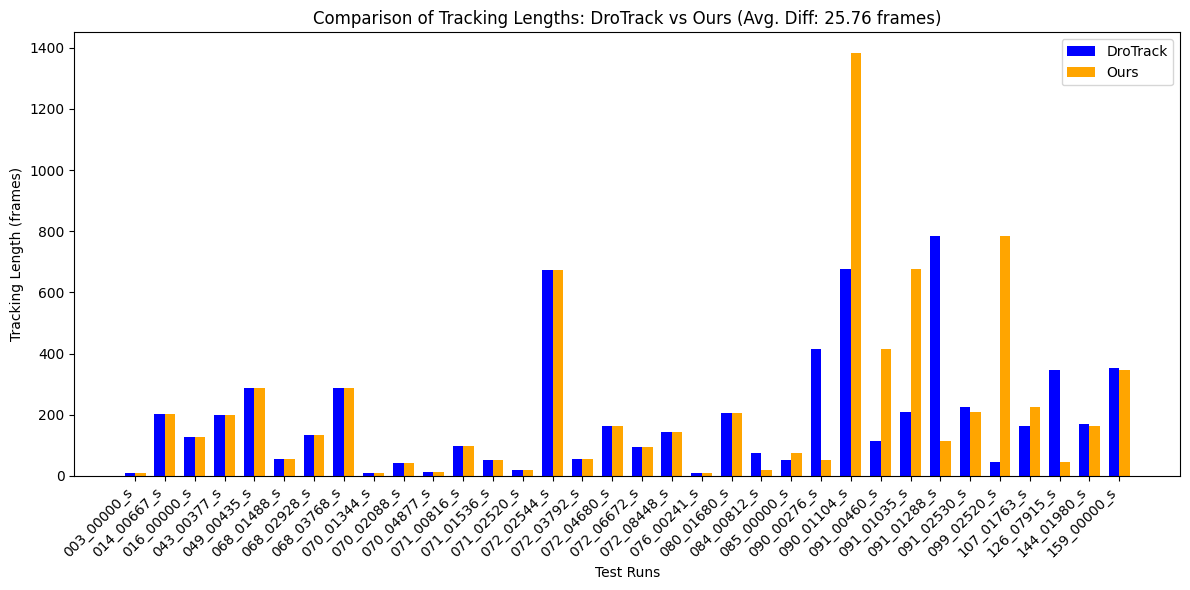

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_histogram(runs_dict_dro, runs_dict_ours, threshold=25, exclude_keys=None):
    # Set default for exclude_keys if not provided
    if exclude_keys is None:
        exclude_keys = set()
    else:
        exclude_keys = set(exclude_keys)

    # Compute tracking lengths for both dictionaries
    def compute_tracking_lengths(runs_dict):
        return {run: sum(data['Center Errors'] < threshold) for run, data in runs_dict.items()}
    
    tracking_lengths_dro = compute_tracking_lengths(runs_dict_dro)
    tracking_lengths_ours = compute_tracking_lengths(runs_dict_ours)
    
    # Combine all keys from both dictionaries and exclude unwanted ones
    all_keys = set(tracking_lengths_dro.keys()).intersection(set(tracking_lengths_ours.keys()))
    filtered_keys = sorted(all_keys - exclude_keys)
    
    # Initialize lists for plotting
    lengths_dro = [tracking_lengths_dro.get(k, 0) for k in filtered_keys]
    lengths_ours = [tracking_lengths_ours.get(k, 0) for k in filtered_keys]

    # Compute the average difference in tracking lengths
    differences = np.array(lengths_ours) - np.array(lengths_dro)
    avg_difference = np.mean(differences)

    # Plot
    x = np.arange(len(filtered_keys))  # The x locations for the groups
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot bars
    ax.bar(x - width/2, lengths_dro, width, label='DroTrack', color='blue')
    ax.bar(x + width/2, lengths_ours, width, label='Ours', color='orange')

    # Add labels, title, and legend
    ax.set_xlabel('Test Runs')
    ax.set_ylabel('Tracking Length (frames)')
    ax.set_title(f'Comparison of Tracking Lengths: DroTrack vs Ours (Avg. Diff: {avg_difference:.2f} frames)')
    ax.set_xticks(x)
    ax.set_xticklabels(filtered_keys, rotation=45, ha="right")
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage with exclusion
exclude = ["089_00920_s"]
plot_comparison_histogram(runs_dict_dro, runs_dict_ours, exclude_keys=exclude)

In [25]:
# Function to calculate average IoU for each run
def compute_average_iou(runs_dict):
    avg_iou = {}
    for run, data in runs_dict.items():
        avg_iou[run] = data['IoUs'].mean()  # Compute the average IoU for each run
    return avg_iou

# Compute average IoU for DroTrack and Ours
avg_iou_dro = compute_average_iou(runs_dict_dro)
avg_iou_ours = compute_average_iou(runs_dict_ours)

# Create a DataFrame to compare the IoUs
iou_comparison_df = pd.DataFrame({
    'Run': list(avg_iou_dro.keys()), 
    'DroTrack IoU': list(avg_iou_dro.values()), 
    'Ours IoU': list(avg_iou_ours.values())
})

# Bold the highest IoU for each run
def bold_highest_iou(row):
    if row['DroTrack IoU'] > row['Ours IoU']:
        return [f'\\textbf{{{x}}}' if x == row['DroTrack IoU'] else x for x in row]
    else:
        return [f'\\textbf{{{x}}}' if x == row['Ours IoU'] else x for x in row]

# Apply bold formatting
iou_comparison_df = iou_comparison_df.apply(bold_highest_iou, axis=1)

# Display the table
print(iou_comparison_df.to_latex(index=False))

ValueError: All arrays must be of the same length